In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import pymc3 as pm
import theano

In [2]:
dat = pd.read_csv('Howell1.csv', sep=';')

# We are interested in adult's height
dat_adults = dat[dat['age'] >= 18]

In [3]:
### Muestreamos de las previas para mu
n_prior          = 10**4

sample_alpha = norm.rvs(size=n_prior, loc=170, scale=10)
sample_beta  = norm.rvs(size=n_prior, loc=0, scale=10)

sample_mu_female = sample_alpha
sample_mu_male   = sample_alpha + sample_beta

/home/dmitri/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


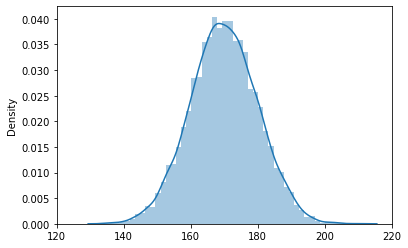

In [4]:
sns.distplot(sample_mu_female)
plt.xlim(120, 220)

#plt.savefig('prior_height_female.png', transparent=True)

/home/dmitri/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


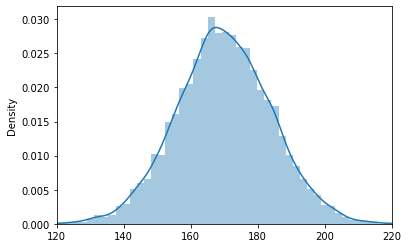

In [5]:
sns.distplot(sample_mu_male)
plt.xlim(120, 220)

#plt.savefig('prior_height_male.png', transparent=True)

In [13]:
with pm.Model() as model:
    alpha_1  = pm.Normal('alpha_1', mu=170, sd=10)
    alpha_2  = pm.Normal('alpha_2', mu=170, sd=10)
    sigma    = pm.Uniform('sigma',  lower=0, upper=50)
    height   = pm.Normal('height',  mu=alpha_1*(dat_adults['male']-1).abs() + alpha_2*dat_adults['male'],
                         sd=sigma, observed=dat_adults['height'])
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha_1, alpha_2, sigma])

In [14]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

In [15]:
sample_alpha_1 = norm.rvs(size=10**4, loc=par_post['alpha_1'], scale=st_dev[0])
sample_alpha_2 = norm.rvs(size=10**4, loc=par_post['alpha_2'], scale=st_dev[1])
sample_sigma   = norm.rvs(size=10**4, loc=par_post['sigma'],   scale=st_dev[2])
sample_diff    = sample_alpha_2 - sample_alpha_1

In [22]:
print(np.round(par_post['alpha_1'],2), np.round(np.quantile(sample_alpha_1, [0.025, 0.975]),2))
print(np.round(par_post['alpha_2'],2), np.round(np.quantile(sample_alpha_2, [0.025, 0.975]),2))
print(np.round(par_post['sigma'],2),   np.round(np.quantile(sample_sigma, [0.025, 0.975]),2))
print(np.round(sample_diff.mean(),2), np.round(np.quantile(sample_diff, [0.025, 0.975]),2))

149.55 [148.75 150.34]
160.38 [159.52 161.22]
5.52 [5.11 5.94]
10.82 [ 9.66 11.97]


### Using theano

In [28]:
with pm.Model() as categorical_model:
    
    x1       = theano.shared(dat_adults['male'].values)
    cat_x1   = pm.Normal('cat_x1', mu=170, sd=10, shape=len(dat_adults['male'].unique()))
    sigma    = pm.Uniform('sigma', lower=0, upper=50)
    
    mu       = cat_x1[x1]
    height   = pm.Normal('height',  mu=mu, sd=sigma, observed=dat_adults['height'])
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[cat_x1, sigma])

In [33]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

In [34]:
sample_alpha_1 = norm.rvs(size=10**4, loc=par_post['cat_x1'][0], scale=st_dev[0])
sample_alpha_2 = norm.rvs(size=10**4, loc=par_post['cat_x1'][1], scale=st_dev[1])
sample_sigma   = norm.rvs(size=10**4, loc=par_post['sigma'],   scale=st_dev[2])
sample_diff    = sample_alpha_2 - sample_alpha_1

In [35]:
print(np.round(par_post['cat_x1'][0],2), np.round(np.quantile(sample_alpha_1, [0.025, 0.975]),2))
print(np.round(par_post['cat_x1'][1],2), np.round(np.quantile(sample_alpha_2, [0.025, 0.975]),2))
print(np.round(par_post['sigma'],2),   np.round(np.quantile(sample_sigma, [0.025, 0.975]),2))
print(np.round(sample_diff.mean(),2), np.round(np.quantile(sample_diff, [0.025, 0.975]),2))

149.55 [148.75 150.34]
160.38 [159.55 161.21]
5.52 [5.1  5.93]
10.83 [ 9.68 11.96]
